# 6.1 결정 트리 학습과 시각화

In [1]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#DecisionTreeClassifier를 훈련시키는 코드
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [3]:
#export_graphviz()를 사용한 그래프 시각화
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='./images/iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

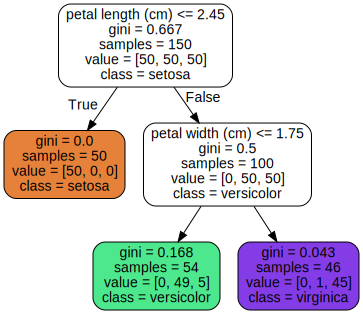

In [4]:

import graphviz

with open("./images/iris_tree.dot", encoding='UTF8') as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='./images', cleanup=True)
dot

* sample : 각 노드로 분류된 데이터의 개수
* value : 각 노드에서 label에 속하는 데이터의 개수
* gini : 불순도(impurity)
 - Gini 계수의 수식 $$
G_i = 1 - \sum_{k=1}^{n}{p_{i,k}^{2}}
$$


# 6.2 예측하기

* 위 붓꽃 종류의 예측 과정
 1. 루트 노드에서 꽃잎의 길이가 2.45cm보다 짧은지 비교
 2. 2.45cm보다 짧다면 왼쪽 노드인 자식 노드로 이동
   - 이때 더 이상의 자식 노드가 없으므로 리프 노드가 된다.
   - 그리고 꽃의 종류를 setosa라고 예측
 3. 반대로, 2.45cm보다 긴 경우 오른쪽 자식 노드로 가며, 꽃잎 너비가 1.75cm보다 짧은지를 비교
 4. 꽃잎의 너비가 1.75cm보다 짧으면 왼쪽 리프 노드로 가게 되며, versicolor라고 예측하며, 1.75cm보다 길면, 오른쪽 리프 노드로 가게되며, virginica로 예측

* DecisionTree는 데이터 전처리가 거의 필요하지 않다. 특히 특성의 스케일을 맞추거나 평균을 원점에 맞추는 작업이 필요하지 않다.

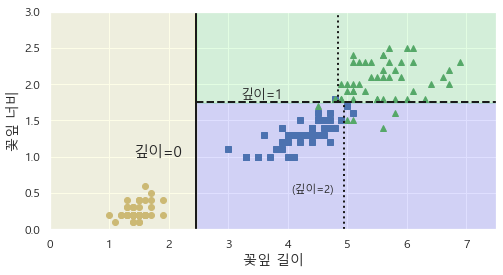

In [5]:
#결정 트리에 대한 결정 경계
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("꽃잎 길이", fontsize=14)
        plt.ylabel("꽃잎 너비", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "깊이=0", fontsize=15)
plt.text(3.2, 1.80, "깊이=1", fontsize=13)
plt.text(4.05, 0.5, "(깊이=2)", fontsize=11)

plt.show()

# 6.3 클래스 확률 추정

* 결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수도 있다.

In [6]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:

tree_clf.predict([[5, 1.5]])

array([1])

# 6.4 CART 훈련 알고리즘

* 사이킷런은 결정 트리를 훈련시키기 위해 CART(Classification And Regression Tree)알고리즘을 사용한다.
* CART 알고리즘은 먼저 학습 데이터셋(train set)을 하나의 특성(feature) $k$의 임계값 $t_k$를 사용해 두 개의 서브셋(child node)로 나눈다.
* CART 알고리즘의 비용 함수(cost function)는 다음과 같다.

$$
J\left(k, t_k \right) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$
- $G_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 불순도(지니계수)
- $m_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 데이터(샘플) 수
* 이와 같은 방법으로 자식 노드로 나누는 과정을 결정 트리의 최대 깊이 또는 불순도를 줄일 수 있는 분할을 찾을 수 없을때까지 반복한다.
* CART알고리즘은 탐욕적 알고리즘(Greedy Algorithm)이다.
* 따라서 최적의 결정 트리를 찾는 것은 NP-완전(NP-Complete)문제이며, O(exp(m))시간이 필요하다.

# 6.5 계산 복잡도

* 예측을 하려면 결정 트리를 루트 노드에서부터 리프 노드까지 탐색해야 한다.
* 일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해 약 O($log_2$(m))개의 노드를 거쳐야 한다.
* 각 노드는 하나의 특성값만 확인하기 떄문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 O($log_2$(m))이다. 그래서 예측속도는 매우 빠르다.
* 훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교한다. 
* 따라서 시간복잡도는  $O(n \times m \log{(m)})$이다. 미리 데이터를 정렬하여 훈련 속도를 높일 수 있지만, 훈련 세트가 클 경우에는 속도가 많이 느려진다.

# 6.6 지니 불순도 또는 엔트로피?

* 기본적으로 지니 불순도가 사용되잠ㄴ criterion 매개변수를 entropy로 지정하여 엔트로피 불순도를 사용할 수 있다.
* 엔트로피는 분자의 무질서함을 측정하는 것으로 한 클래스의 샘플만 담고 있다면 엔트로피가 0이다.

* 엔트로피 계수
$$
H_i = - \sum_{\underset{p_{i,k} \neq 0}{k=1}}^{n}{p_{i,k} \log_{2}{\left( p_{i, k} \right)}}
$$
* 기본적으로 지니 불순도가 조금 더 계산이 빠르기 때문에 기본값으로 좋다.
* 하지만 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한족 가지로 고립시키는 경향이 있는 반면 엔트로피는 조금 더 균형 잡힌 트리를 만든다.

# 6.7 규제 매개변수

* 비파라미터 모델(Nonparametric Model) : 훈련되기 전에 파라미터 수가 결정되지 않는 모델
* 파라미터 모델(Parametric Model) : 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합될 위험이 줄어든다.
* 훈련 데이터에 대한 과대적합을 피하기 위해 학습할 때 결정 트리의 자유도를 제한할 필요가 있다. 이를 규제라고 한다.
* 사이킷런에서는 max_depth 매개변수로 이를 조절한다. max_depth를 줄이면 모델을 규제하게 되고 과대적합의 위험이 감소한다.
* DecisionTreeClassifier에서는 트리의 깊이(max_depth) 뿐만 아니라 규제를 하기위한 다른 인자들이 있다.아래의 매개변수에서 min_으로 시작하는 매개변수를 증가 시키거나, max_로 시작하는 매개변수를 감소시키면 모델에 규제가 커진다.
 - min_sample_split(분할되기 위해 노드가 가져야 하는 최소 샘플 수)
 - min_samples_leaf(리프 노드가 가지고 있어야 하는 최소 샘플 수)
 - min_weight_fraction_leaf(가중치가 부여된 전체 샘플 수에서의 비율)
 - max_leaf_nodes(리프 노드의 최대 수)
 - max_features(각 노드에서 분할에 사용할 특성의 최대 수)

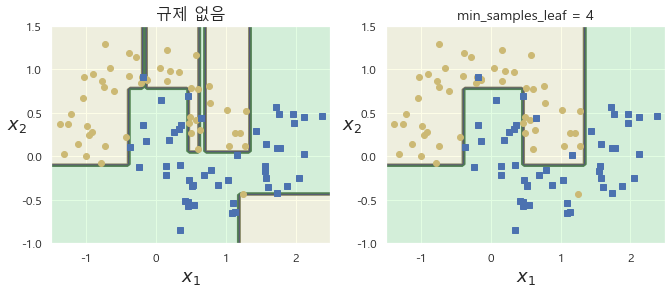

In [8]:
#moons 데이터셋 위의 매개변수 중 min_samples_leaf 매개변수를 변화시켜 학습
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("규제 없음", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

* 가지치기(Pruning)
 - 제한없이 결정 트리를 훈련시키고 불필요한 노드를 제거하는 알고리즘
 - 순도를 높이는 것이 통계적으로 큰 효과가 없다면 리프 노드 바로 위의 노드는 불필요하다고 할 수 있다. 이렇게 판단하는 기준은 $\chi^{2}$ 검정(chi-squared, 카이 제곱검정)을 사용하며, $p$-value 값이 $0.05$보다 높으면 해당 노드는 불필요한 노드로 추정하여 해당 노드의 자식 노드를 가지치기 한다.

# 6.8 회귀

In [9]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(max_depth=2)

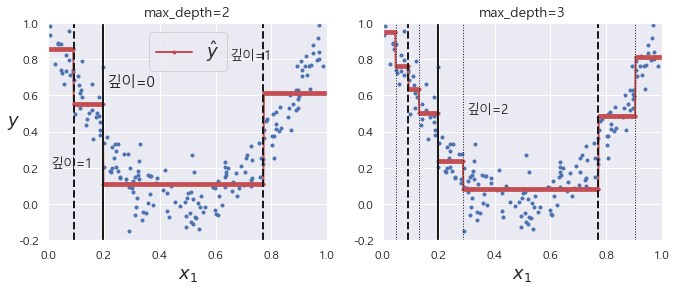

In [11]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "깊이=0", fontsize=15)
plt.text(0.01, 0.2, "깊이=1", fontsize=13)
plt.text(0.65, 0.8, "깊이=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "깊이=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [12]:
export_graphviz(
        tree_reg1,
        out_file="./images/regression_tree.dot",
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

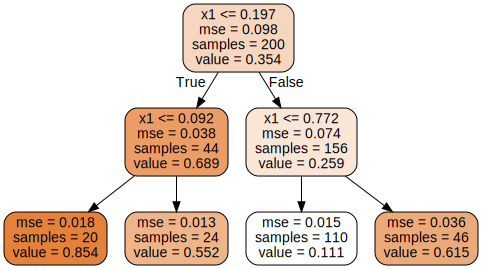

In [13]:
import graphviz
with open("./images/regression_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='regression_tree', directory='./images/decision_trees', cleanup=True)
dot

* CART 알고리즘은 학습 데이터셋을 평균제곱오차(MSE)를 최소화하도록 트리를 분할한다.

$$
J\left(k, t_k \right) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}}
$$$$
\begin{cases} \text{MSE}_{\text{node}} = \sum_{i \in \text{node}}{\left( \hat{y}_\text{node} - y_i \right)^{2}} \\ \hat{y}_\text{node} = \frac{1}{m_\text{node}}\sum_{i \in \text{node}}{y_i} \end{cases}
$$

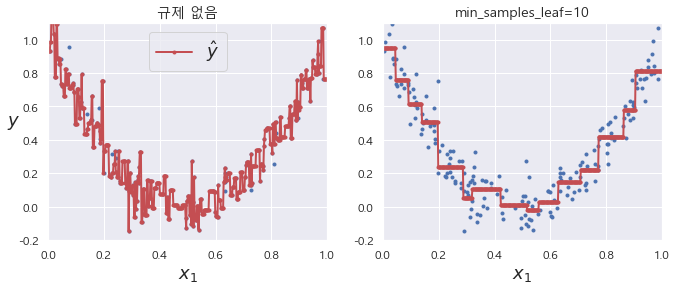

In [14]:
#규제가 없는 경우와 min_sample_leaf = 10을 지정한 경우
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("규제 없음", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

# 6.9 불안정성

* 결정 트리의 큰 단점은 학습 데이터셋 변화에 민감하다는 것이다.
* 이런 문제를 해결하는 방법은 PCA기법을 사용한다.

In [15]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # 가장 너비가 큰 Iris-Versicolor

array([[4.8, 1.8]])

In [16]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

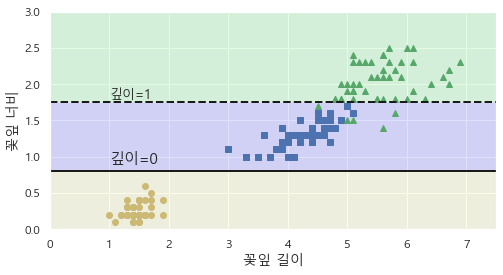

In [17]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "깊이=0", fontsize=15)
plt.text(1.0, 1.80, "깊이=1", fontsize=13)

plt.show()